In [84]:
using LinearAlgebra
using Printf
using Plots

global const µ = 3.986e14  # m^3/s^2

# Helper function to take the column-wise norms of a matrix
norm_col(A) = [norm(A[:,i]) for i=1:size(A,2)]

norm_col (generic function with 1 method)

In [226]:
function feval(x,p,u)
    # Function eval with input x formatted as:
    # r_1x, r_1y, r_1z, v_1x, v_1y, v_1z, r_2x, r_2y, ...
    # 3-vec of position followed by 3-vec of velocity for each node
    
    # Optionally modify the exponential decay constant (d) and force amplitude (k) here
    d = 1000
    k = 100
    
    N = length(x);
    f = zeros(N);
    
    # Derivative of position is velocity
    f[1:6:end] = x[4:6:end]  # x axis
    f[2:6:end] = x[5:6:end]  # y axis
    f[3:6:end] = x[6:6:end]  # z axis
    
    # Calculate -µ/|r|^3 for each node
    # Reshape x into 3 x N/3 and take every other col -> get just positions, not velocities
    dists = norm_col(reshape(x, 3, floor(Int, N/3))[:,1:2:end])
    grav_terms = -µ * dists.^-3
    
    # Set gravitational acceleration as r * (-µ/|r|^3)
    f[4:6:end] = x[1:6:end].*grav_terms
    f[5:6:end] = x[2:6:end].*grav_terms
    f[6:6:end] = x[3:6:end].*grav_terms
    
    for i in 1:floor(Int, N/6)  # For each node,
        for j in 1:floor(Int, N/6)  # Loop over each other node
           if i != j  # And add the contributions from the interactions between nodes
                # Will update later with better function vectorization =) Julia is new
                # (This also calculates each force twice, unnecessarily...)
                idx_i = (i-1)*6
                idx_j = (j-1)*6
                # Vector of position from node i to note j
                r_ij = x[1+idx_i:3+idx_i] - x[1+idx_j:3+idx_j]
                dist = norm(r_ij)
                f[4+idx_i:6+idx_i] += k*exp(-d*dist) * r_ij/dist   
            end
        end
    end
    return f
end

feval (generic function with 1 method)

In [71]:
# Func test
x = feval([1,2,3,4,5,6,7,8,9,10,11,12],0,0)
# Checked by hand; agrees with calculations

12-element Vector{Float64}:
  4.0
  5.0
  6.0
 -7.609309359020883e12
 -1.5218618718041766e13
 -2.282792807706265e13
 10.0
 11.0
 12.0
 -1.0326014712243367e12
 -1.1801159671135276e12
 -1.3276304630027185e12

In [159]:
function f(x)
    return feval(x,0,0)
end

function euler(f, x0, xn, y0, n)
    # Use the forward euler method to propagate the orbits
    # x0: initial time
    # xn: final time
    # n: number of steps
    # y0: initial state

    h = (xn - x0)/n  # time step
    xs = zeros(floor(Int,n+1))
    ys = zeros(floor(Int,n+1),length(y0))
    xs[1] = x0
    ys[1,:] = y0
    
    for i in 1:floor(Int,n)
        xs[i + 1] = xs[i] + h
        ys[i + 1,:] = ys[i,:] + h * f(ys[i,:])
    end
    
    return ys
end

euler (generic function with 1 method)

In [160]:
function energy(x)
    # Calculate total specific kinetic + gravitational potential energy for each object to check for conservation
    # Won't be entirely accurate because it doesn't account for potential between objects
    
    # gravitational: -mu/r
    # kinetic: 1/2 v^2
    
    dists = norm_col(reshape(x, 3, floor(Int, length(x)/3))[:,1:2:end])
    U = -µ ./dists
    
    vels = norm_col(reshape(x, 3, floor(Int, length(x)/3))[:,2:2:end])
    K = 1/2 * vels.^2
    
    return sum(U)+sum(K)
end

energy (generic function with 1 method)

In [161]:
radius = 7e6  # m
velocity = sqrt(µ/radius)

x0 = [radius, 0, 0, 0, velocity, 0]
t0 = 0
ti = 2*pi*radius^1.5/µ^0.5  # Should result in 1 orbit
num_steps = 1000
xs = euler(f, t0, ti, x0, num_steps)

1001×6 Matrix{Float64}:
 7.0e6          0.0        0.0     0.0     7546.05  0.0
 7.0e6      43982.3        0.0   -47.4132  7546.05  0.0
 6.99972e6  87964.6        0.0   -94.8236  7545.75  0.0
 6.99917e6      1.31945e5  0.0  -142.229   7545.16  0.0
 6.99834e6      1.75922e5  0.0  -189.629   7544.26  0.0
 6.99724e6      2.19894e5  0.0  -237.019   7543.07  0.0
 6.99586e6      2.63859e5  0.0  -284.4     7541.58  0.0
 6.9942e6       3.07815e5  0.0  -331.768   7539.8   0.0
 6.99226e6      3.51761e5  0.0  -379.122   7537.71  0.0
 6.99005e6      3.95695e5  0.0  -426.461   7535.33  0.0
 6.98757e6      4.39615e5  0.0  -473.781   7532.65  0.0
 6.98481e6      4.83519e5  0.0  -521.082   7529.67  0.0
 6.98177e6      5.27406e5  0.0  -568.362   7526.4   0.0
 ⋮                                                  ⋮
 6.93992e6     -2.94087e6  0.0  2826.86    6684.98  0.0
 6.95639e6     -2.9019e6   0.0  2789.21    6700.94  0.0
 6.97265e6     -2.86285e6  0.0  2751.47    6716.68  0.0
 6.98869e6     -2.8237e6  

Final energy / initial energy: 1.073376393565921


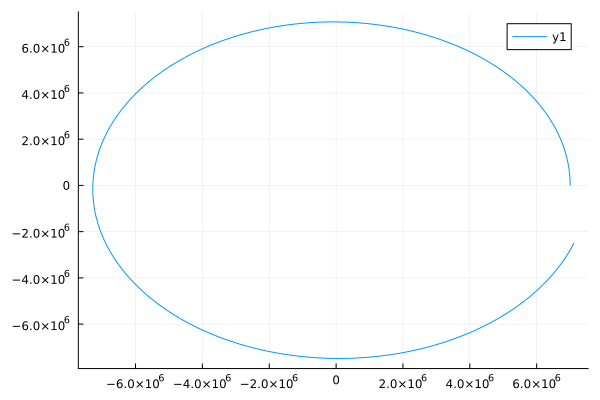

In [162]:
println("Final energy / initial energy: ",energy(x0)/energy(xs[num_steps+1,:]))
plot(xs[:,1], xs[:,2])

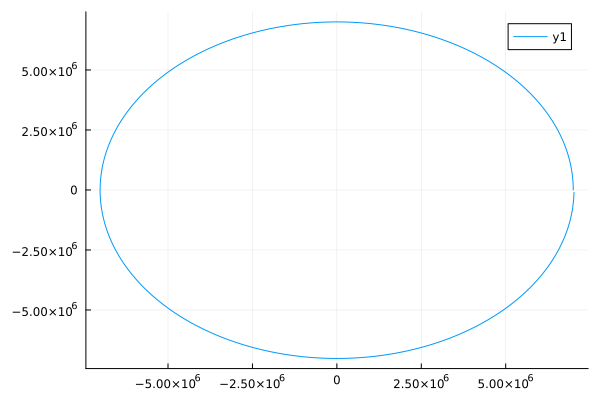

In [215]:
count = 500
energy_ratio = zeros(count)
steps = zeros(count)
for i in 1:count
    x0 = [radius, 0, 0, 0, velocity, 0]
    t0 = 0
    ti = 2*pi*radius^1.5/µ^0.5  # Should result in 1 orbit
    steps[i] = 50*i
    xs = euler(f, t0, ti, x0, steps[i])
    energy_ratio[i] = abs(energy(x0)/energy(xs[floor(Int,steps[i]+1),:]))
end

plot(xs[:,1], xs[:,2])

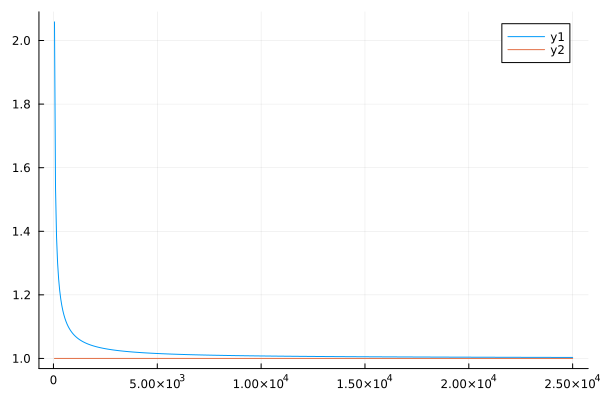

In [216]:
plot(steps,[energy_ratio,ones(count)])

In [217]:
energy_ratio[157]

1.009958496099777

In [218]:
steps[157]

7850.0

In [219]:
println("Minimum time step for 1% error after 1 orbit [seconds]: ", (ti-t0)/steps[157])

Minimum time step for 1% error after 1 orbit [seconds]: 0.74248660736163


In [220]:
# However, forward euler is unstable even for small time steps,
# because it always results in an orbit of increasing size due to linearization.

# We will need to use a more advanced method for our project.

radius = 7e6  # m
velocity = sqrt(µ/radius)

x0 = [radius, 0, 0, 0, velocity, 0]
t0 = 0
ti = 100 * 2*pi*radius^1.5/µ^0.5  # Should result in 100 orbits
num_steps = 100 * 1000
xs = euler(f, t0, ti, x0, num_steps)

100001×6 Matrix{Float64}:
  7.0e6          0.0        0.0     0.0        7546.05  0.0
  7.0e6      43982.3        0.0   -47.4132     7546.05  0.0
  6.99972e6  87964.6        0.0   -94.8236     7545.75  0.0
  6.99917e6      1.31945e5  0.0  -142.229      7545.16  0.0
  6.99834e6      1.75922e5  0.0  -189.629      7544.26  0.0
  6.99724e6      2.19894e5  0.0  -237.019      7543.07  0.0
  6.99586e6      2.63859e5  0.0  -284.4        7541.58  0.0
  6.9942e6       3.07815e5  0.0  -331.768      7539.8   0.0
  6.99226e6      3.51761e5  0.0  -379.122      7537.71  0.0
  6.99005e6      3.95695e5  0.0  -426.461      7535.33  0.0
  6.98757e6      4.39615e5  0.0  -473.781      7532.65  0.0
  6.98481e6      4.83519e5  0.0  -521.082      7529.67  0.0
  6.98177e6      5.27406e5  0.0  -568.362      7526.4   0.0
  ⋮                                                     ⋮
 -2.0394e7      -3.4162e5   0.0   -27.1412    -4420.11  0.0
 -2.03942e7     -3.67383e5  0.0   -21.5577    -4420.01  0.0
 -2.03943e7     

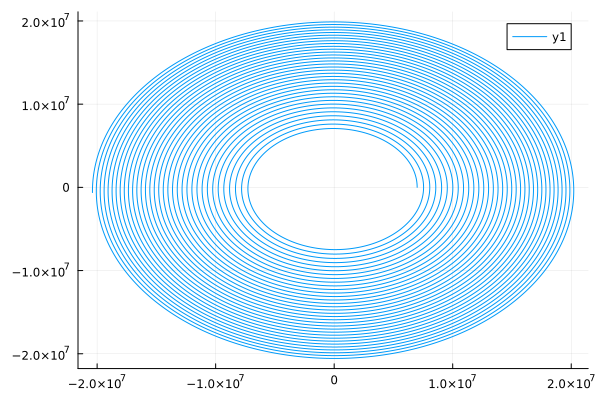

In [221]:
plot(xs[:,1], xs[:,2])

In [232]:
# Test on multiple objects! Separated by 1 meter in the binormal

x0 = [radius, 0, -0.5, 0, velocity, 0, radius, 0, 0.5, 0, velocity, 0]
t0 = 0
ti = 2*pi*radius^1.5/µ^0.5
num_steps = 10000
xs = euler(f, t0, ti, x0, num_steps)

10001×12 Matrix{Float64}:
 7.0e6          0.0        -0.5       …    0.0      7546.05   0.0
 7.0e6       4398.23       -0.5           -4.74132  7546.05  -3.38666e-7
 7.0e6       8796.46       -0.5           -9.48264  7546.05  -6.77332e-7
 6.99999e6  13194.7        -0.499999     -14.224    7546.04  -1.016e-6
 6.99998e6  17592.9        -0.499999     -18.9653   7546.03  -1.35466e-6
 6.99997e6  21991.1        -0.499998  …  -23.7066   7546.02  -1.69333e-6
 6.99996e6  26389.3        -0.499997     -28.4479   7546.0   -2.03199e-6
 6.99994e6  30787.5        -0.499996     -33.1891   7545.99  -2.37065e-6
 6.99992e6  35185.7        -0.499994     -37.9304   7545.97  -2.70931e-6
 6.9999e6   39583.9        -0.499993     -42.6716   7545.94  -3.04797e-6
 6.99988e6  43982.1        -0.499991  …  -47.4129   7545.92  -3.38663e-6
 6.99985e6  48380.2        -0.499989     -52.1541   7545.89  -3.72529e-6
 6.99982e6  52778.4        -0.499987     -56.8953   7545.85  -4.06395e-6
 ⋮                                

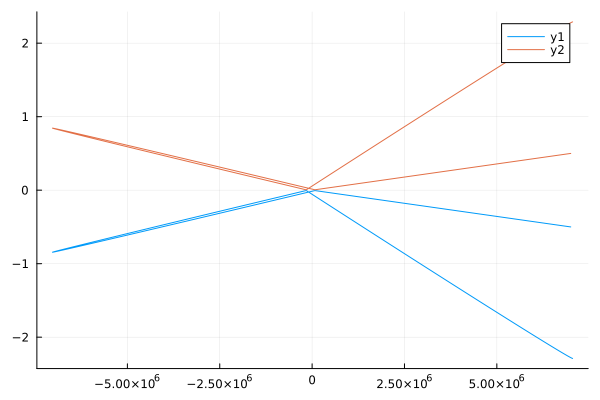

In [233]:
plot([xs[:,1], xs[:,7]], [xs[:,3], xs[:,9]])

In [235]:
abs(energy(x0)/energy(xs[num_steps + 1,:]))

1.0078340537416106

In [236]:
function trapezoidal(f, x0, xn, y0, n)
    # Use the trapezoidal method to propagate the orbits
    # x0: initial time
    # xn: final time
    # n: number of steps
    # y0: initial state

    h = (xn - x0)/n  # time step
    xs = zeros(floor(Int,n+1))
    ys = zeros(floor(Int,n+1),length(y0))
    xs[1] = x0
    ys[1,:] = y0
    
    for i in 1:floor(Int,n)
        xs[i + 1] = xs[i] + h
        #ys[i + 1,:] = ys[i,:] + h * f(ys[i,:])
        ys[i+1,:] = NewtonNd(xs[i],h,0, 1e-10, 1e-8, 1e-8, 100, false, false)
    end
    
    return ys
end

euler (generic function with 1 method)